## Семинар 7: "Методы оптимизации"

ФИО:

In [44]:
import numpy as np
#from sklearn.datasets import fetch_mldata
#from sklearn.cross_validation import train_test_split
import matplotlib.pyplot as plt
import torch
from torch import nn
from torch.autograd import Variable
import seaborn as sns
%matplotlib inline

На этом семинаре мы попробуем сравнить различные методы оптимизации: GD, Momentum, NAG, Adagrad, Adadelta, Adam.

### Часть 1: Реализация методов

Полезная функция: plt.contour
Для всех экспериментов подберите параметры так, чтобы метод сошелся к ближайшему локальному минимуму. Все методы следует запускать из одной и той же точки.

<i> 1.1 Реализуйте методы GD, Momentum, NAG, Adagrad, Adadelta, Adam.</i>

In [122]:
class Optimizer:
  def __init__(self, parameters):
    self.parameters = parameters

  def zero_grad(self):
    for param in self.parameters:
      try:
        param.grad.zero_()
      except:
        pass
  
  def step(self, F):
    loss = F()
    loss.backward()

class SGD(Optimizer):
  def __init__(self, parameters, lr=0.1):
    self.parameters = parameters
    self.lr = lr
  
  def step(self, F):
    super().step(F)

    with torch.no_grad():
      for param in self.parameters:      
        param -= self.lr * param.grad
        #param.__idiff__(self.lr * param.grad)
        #param = param - self.lr * param.grad
        #param.set_(param - self.lr * param.grad)

class Momentum(Optimizer):
  def __init__(self, parameters, lr=0.1, gamma=0.9):
    self.parameters = parameters    
    self.params_step = [torch.zeros_like(param) for param in self.parameters]

    self.lr = lr
    self.gamma = gamma
  
  def step(self, F):
    super().step(F)

    with torch.no_grad():
      for param, step in zip(self.parameters, self.params_step):
        step.set_(self.gamma * step + self.lr * param.grad)
        param -= step

class NAG(Optimizer):
  def __init__(self, parameters, lr=0.1, gamma=0.9):
    self.parameters = parameters    
    self.params_step = [torch.zeros_like(param) for param in self.parameters]

    self.lr = lr
    self.gamma = gamma
  
  def step(self, F):
    with torch.no_grad():
      for param, step in zip(self.parameters, self.params_step):
        param -= self.gamma * step

    super().step(F)

    with torch.no_grad():
      for param, step in zip(self.parameters, self.params_step):
        param += self.gamma * step
        
        step.set_(self.gamma * step + self.lr * param.grad)
        param -= step

class Adadelta(Optimizer):
  def __init__(self, parameters, gamma=0.9):
    self.parameters = parameters    
    self.params_gs = [torch.zeros_like(param) for param in self.parameters]

    self.first_call = True    

    self.lr = 1
    self.gamma = gamma
    self.eps = 0.00001
  
  def step(self, F):
    super().step(F)

    sum_step = 0
    num_params = 0
    with torch.no_grad():
      for param, gs in zip(self.parameters, self.params_gs):
        if self.first_call:
          gs.set_(param.grad**2)
        else:
          gs.set_(self.gamma * gs + (1.0 - self.gamma) * param.grad**2)

        step = self.lr / (gs + self.eps).sqrt() * param.grad

        sum_step += step.sum()
        num_params += step.numel()

        param -= step

    self.lr = self.gamma * self.lr + (1 - self.gamma) * sum_step / num_params

    self.first_call = False

<i> 1.2 Сравните эти методы на функции $J(x, y) = x^2+y^2$</i>

In [127]:
# sin(x) + cos(y)

def f(x):
  return x[0].sin() + x[1].cos() + (x.sum())**2
  #return (x**2).sum(axis=-1)

optimizers = [(SGD, "red"), (Momentum, "green"), (NAG, "blue"), (Adadelta, "black")]

all_ways = []

for optimizer, _ in optimizers:
  x = nn.Parameter(torch.tensor([0.5, 0.7]))
  optimizer = optimizer([x])

  points = []
  for i in range(5):  
      optimizer.zero_grad()
      optimizer.step(lambda x=x: f(x))

      points.append(x.detach().numpy().copy())
      #print(points[-1])

  print(f(x))

  points = np.array(points)
  all_ways.append(points)

tensor(0.4515, grad_fn=<AddBackward0>)
tensor(1.1094, grad_fn=<AddBackward0>)
tensor(-0.0284, grad_fn=<AddBackward0>)
tensor(-0.4245, grad_fn=<AddBackward0>)


AttributeError: ignored

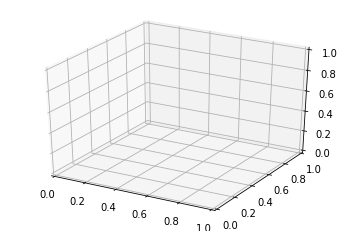

In [105]:
from mpl_toolkits.mplot3d import axes3d
import matplotlib.pyplot as plt
import numpy

def cartesian_product(*arrays):
    la = len(arrays)
    dtype = numpy.result_type(*arrays)
    arr = numpy.empty([len(a) for a in arrays] + [la], dtype=dtype)
    for i, a in enumerate(numpy.ix_(*arrays)):
        arr[...,i] = a
    return arr.reshape(-1, la)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

size = 10
n = 100

X = np.linspace(-size, size, n)
Y = np.linspace(-size, size, n)

Z = f(cartesian_product(X, Y)).reshape(n, n)

#print(Z)

#ax.plot_wireframe(X, Y, Z, rstride=10, cstride=10)
ax.plot_wireframe(X, Y, Z)

plt.show()

(1.9041341185569762, 4.928708469867706, 1.681746530532837, 4.110130262374878)

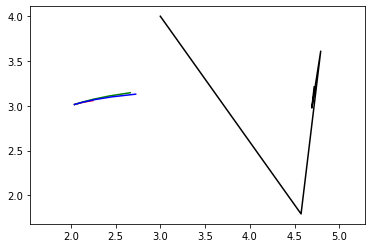

In [126]:
for points, (_, color) in zip(all_ways, optimizers):
  plt.plot(points[:, 0], points[:, 1], c=color)

plt.axis('equal')

In [48]:
plot

<i>1.3 Сравните эти методы на функции $J(x, y) = x^2sin(x)+y^2sin(y)$</i>

<i>1.3 Сравните эти методы на функции $J(x,y)=x^2sin(x^2)+y^2sin(y^2)$</i>

###  Часть 2: Обучение нейронной сети

<i> 2.1 Сравните графики обучения для полносвязной нейросети на методах Adam, Adagrad, AdaDelta и SGD (на MNIST). </i>

<i> 2.2 Сравните графики обучения для сверточной нейросети на методах Adam, Adagrad, AdaDelta и SGD. </i>

#### Feedback (опционально)

Здесь вы можете оставить список опечаток из лекции или семинара:

Здесь вы можете оставить комментарии по лекции или семинару: